<a id=top></a>
# Leavitt's Footsteps
***

## Prerequisites
Before beginning this tutorial, you should be familiar with: 
- Python syntax, including 

TBD

## Learning Goals: 
By the end of this tutorial, you will:
- Get light curves from TESS
- Analyze those lightcurves for periodic changes
- Query complimentary data
- Discover how the observable stellar properties can be correlated with the intrinsic stellar properties

## Introduction

TBD

The workflow for this notebook consists of:
* Links

## Imports
- *matplotlib.pyplot* for plotting data
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *astropy.wcs* and *astropy.coordinates SkyCoord* for keeping track of sky coordinates
- *astroquery.mast Catalogs* and *Observations* for searching the MAST archive
- *astroquery.mast Tesscut* for downloading target-pixel files from TESS data
- *lightkurve* for creating and viewing lightcurves from TESS data

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut

import lightkurve as lk

Don't forget to enable cloud data access!

In [7]:
Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


***

### A Curious Star

One of your colleagues was looking at their observations, and noticed a weird looking pattern in the light curve of one star (RA= 001.50821, DEC=-36.90425) . Given your knowledge of stellar physics, they brought it to you to ask what it could be. To answer them, you boot up the TIKE workspace to look at TESS data. You check the coordinates of this star- does it have TESS data?

In [8]:
# Entering our coordinates from above
ra1=001.50821
dec1=-36.90425

coordinates = SkyCoord(ra1, dec1, frame = "icrs", unit='deg') #defaults to ICRS frame 
print(coordinates)

# Search on coordinates with 2 second radius
obs = Observations.query_region(coordinates, radius = "2s")

#Let's look at the first five rows
print(obs[:5])

<SkyCoord (ICRS): (ra, dec) in deg
    (1.50821, -36.90425)>
intentType obs_collection provenance_name ... srcDen  obsid   distance
---------- -------------- --------------- ... ------ -------- --------
   science           TESS            SPOC ...    nan 60902961      0.0
   science           TESS            SPOC ...    nan 27972861      0.0
   science           HLSP         ELEANOR ...    nan 32138786      0.0
   science           HLSP         ELEANOR ...    nan 32130581      0.0
   science           HLSP         ELEANOR ...    nan 32130445      0.0


In [9]:
#Let's parse these observations for just those from TESS
tess_obs = (obs['obs_collection'] == "TESS")

# Print out the observations we have queried 
obs[tess_obs]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str5,str17,str10,str4,str4,str7,str32,str1,str73,float64,float64,str10,str17,int64,float64,float64,float64,float64,float64,str1,float64,str23,str3,int64,str132,str117,str129,str6,bool,float64,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0002-2-3,8.151463924375765,-35.88059435474311,image,"Ricker, George",3,58353.608391458336,58381.00446899306,1425.599438,600.0,1000.0,--,58458.5833333,N/A,--,2,POLYGON 10.091751 -27.902511 18.647434 -36.84455 5.683885 -44.112876 358.123009 -33.748897 10.091751 -27.902511,--,--,PUBLIC,False,nan,60902961,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0029-2-4,357.33223193278087,-40.60382212536179,image,"Ricker, George",3,59087.74028324,59113.93440376,475.199793,600.0,1000.0,--,59158.0,N/A,--,29,POLYGON 0.82481000 -32.57857300 8.21854600 -42.96448800 352.47581800 -48.37273000 347.66759100 -37.43753800 0.82481000 -32.57857300,--,--,PUBLIC,False,nan,27972861,0.0


Oh good, there seems to be TESS data for this object. TESS's observations are divided into 27 day long sectors (see https://heasarc.gsfc.nasa.gov/docs/tess/primary.html for more details). There is a handy python package called Tesscut that allows us to do access the data more easily. To use it, we have to give it the set of coordinates we want to look at. Which sectors was this target observed in?

In [10]:
Tesscut.get_sectors(coordinates=coordinates)

sectorName,sector,camera,ccd
str14,int64,int64,int64
tess-s0002-2-3,2,2,3
tess-s0029-2-4,29,2,4


Now that we know that the data exist, we want to pick one of these observations and actually look at it, and so we ask TESScut to get us small (10 pixel) cutouts from one of these sectors

In [11]:
hdulist = Tesscut.get_cutouts(coordinates=coordinates, size=10    # return a 10x10 grid of pixels
                              , sector=2  # get only data from sector 2
                             )
hdulist

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f3f441bd850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f3f44159a30>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f3f904e4f40>]]

Look at the information for the thing we just downloaded- we've been given a fits file with High Density Unit (HDU) 1 holding the image information, and HDU 2 holding information about the apertures for the stars in it. 

In [12]:
hdulist[0].info()
#hdulist[0][1].header

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  PIXELS        1 BinTableHDU    281   1245R x 12C   [D, E, J, 100J, 100E, 100E, 100E, 100E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        82   (10, 10)   int32   


In [13]:
# Define a function to simplify the plotting command that we can do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Okay, let's actually plot the first frame of the dataseries, showing the flux of each star on the little part of the CCD we downloaded. 

Text(0, 0.5, 'Image Row')

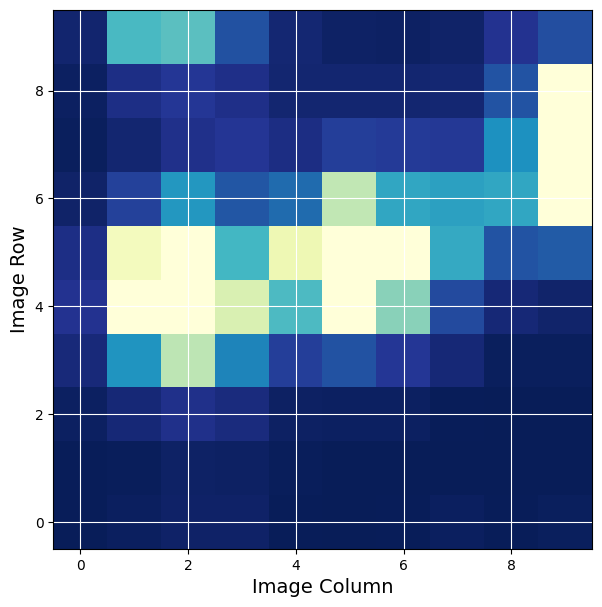

In [14]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

### Exercise 1: 

Describe the image that you see. Why are there multiple bright regions?

In [19]:
# Write your answer for Exercise 1 here


## Adding GAIA identifiers
Luckily, there is another mission called Gaia that is identifying the positions of all the stars in the sky. Let's plot what Gaia knows about this part of the sky on top of the image. To do that, we use a set of functions from Catalogs to access that catalog of data.

In [16]:
radSearch = 2/60 #radius in degrees
coordstring=str(ra1)+' '+str(dec1)

In [17]:
catalogData = Catalogs.query_object(coordstring, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:10]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

# Create a list of nearby bright stars (tess magnitude less than 20) from the rest of the data for later.
bright = catalogData['Tmag'] < 16 
#faint = catalogData['Tmag'] > 15
#band=bright*faint
#print(band)

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
120488286 13.1434  12.54 1.50815926825826 -36.9041890229087    STAR
120488285 15.5561 14.296 1.49928341095074 -36.9129396742459    STAR
120488284 16.2054 15.001 1.49369542262342 -36.9189252884794    STAR
120488287 13.0008 12.399   1.526843917294 -36.8923236406745    STAR
609912715 19.1178    nan 1.52150212264988 -36.8803418822856    STAR
120461434 12.7995 12.176 1.48747585028645 -36.9275920019391    STAR
120488289 18.0358 16.648 1.50951766759936 -36.8756337482558    STAR
609912655 17.5056    nan 1.50146865548709 -36.9329094269333    STAR
609912686 20.4367    nan 1.47339877026035 -36.8943910463969    STAR
609912714 19.7118    nan 1.54609257692782 -36.8910571204167    STAR


4

Okay so there are lots of stars in this area of the sky. Which ones are the ones we care about?

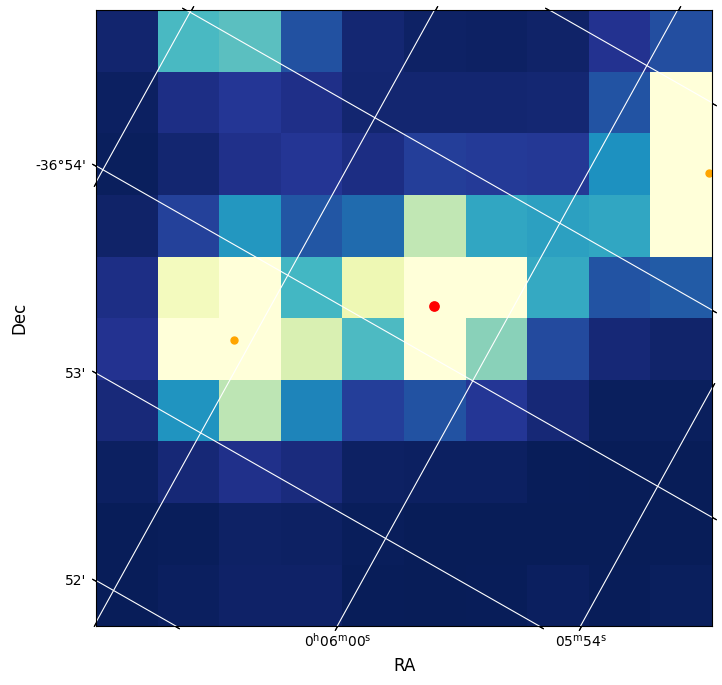

In [18]:
wcs = WCS(hdu1[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)

starloc = wcs.all_world2pix([[ra1,dec1]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

### Exercise 2:
What is the name for the star on the left, and what is the name for the star on the right? 

In [21]:
# Write your code for Exercise 2 here


## Using lightkurve to save a lightcurve of one target star
Now that we know what the two stars are, how do we know which one has the interesting variability?

Luckily, someone has also made a tool to do this, it's called lightkurve (with a k), and it will allow us to look at how the light from each star changes over time by turning the brightness of each of these pixels into a timeseries (or light curve). 

In [22]:
#movie = hdu1[1].data['FLUX']
name=catalogData[bright]['ID'][0]
name='TIC'+str(name)

In [23]:
search_result=lk.search_tesscut(name, sector=2)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,TESScut,1426,TIC120488286,0.0


We're going to use a slightly different size of cutout ("target pixel file", or tpf) here so we can see more stars.

In [24]:
tpf = search_result.download(cutout_size=15)

This package also gives us a very handy 'interact' fuction that allows us to click on a pixel, and see what its raw light curve looks like.

In [27]:
tpf.interact()

By clicking on the pixel data and selecting different masks, can you tell which star is the weirdly variable one (particular to one star), and which ones are dominated by the detector systematics (similar for every star)? (Shift/Control/Command should allow you to select and deselect individual pixels)

### Exercise 3:

How many different stars are included in the first light curve you are shown? Which of those stars has the unique variability that drew the attention of your colleague? 

In [ ]:
# Write your code for Exercise 3 here


## Using lightkurve to visualize and calculate stellar variability

Once you have selected only the star that is weirdly variable, use the 'Save Lightcurve' button on the bottom left to save a copy of that lightcurve. (Mine was named 'TESS_TIC120488286_custom-lc.fits')

NOTE: Using only the central pixel, not background subtracting?

Now read in that lightcurve, and plot it. (lightcurve also has handly functions for this)

In [37]:
tesslc = lk.io.read('TESS_TIC120488286_custom-lc.fits')

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

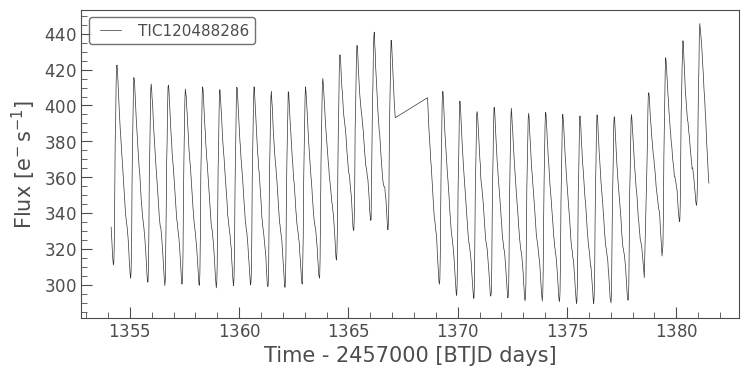

In [38]:
tesslc.plot()

### Exercise 4
Describe the shape of the variability of this star in words. Is it symmetric? What is the approximate period?

In [39]:
# Write your answer for Exercise 4 here


We can also use a variation of the Fourier Transform (called a Lomb-Scargle Periodogram) to identify the strongest frequency of variation exactly. Luckily, lightkurve also has a function for that.

In [40]:
pgrm=tesslc.to_periodogram()

Show the periodogram:

(0.0, 10.0)

<Figure size 700x700 with 0 Axes>

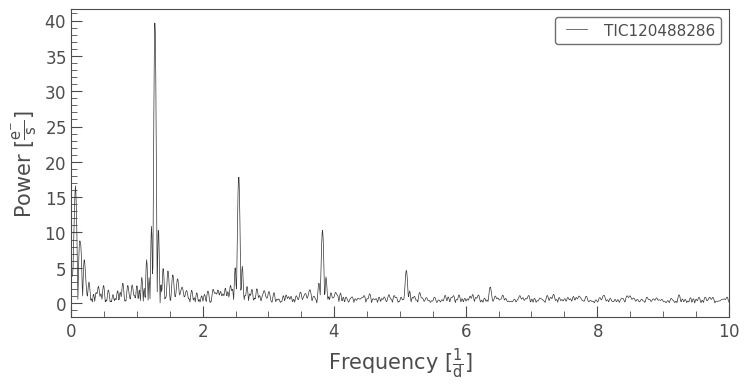

In [41]:
fig = plt.figure(figsize=(7, 7))
pgrm.plot()
plt.xlim([0,10])


In this case, the highest peak represents the actual period of variability, and the other peaks are located at *harmonics* of that frequency (2 x frequency, 3 x frequency, 4 x frequency and so on)

Lightkurve also has a function that will allow you to identify the period of the highest peak

In [42]:
period = pgrm.period_at_max_power
print(period)

0.7860462791530743 d


Now that we have the period, let's check that it looks right. To do that, we fold the data so that each period is plotted on top of the next period. If we really have the right period, all of the peaks will line up. 

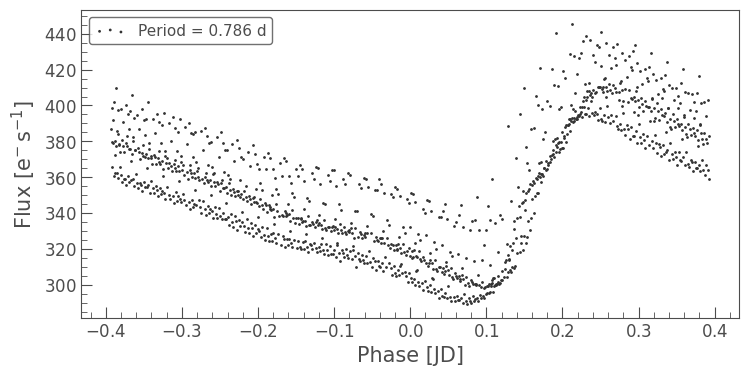

In [43]:
tesslc.fold(period).scatter(label=f'Period = {period.value:.3f} d');

What if the period were off by 1%. What would that plot look like?

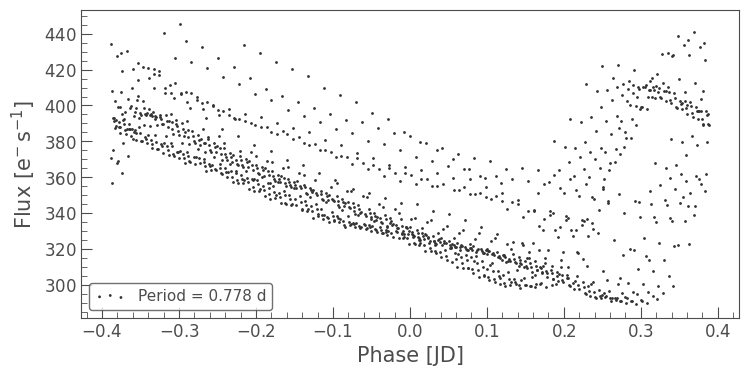

In [44]:
period2=period*.99
tesslc.fold(period2).scatter(label=f'Period = {period2.value:.3f} d');

### Exercise 5
What if the period were off by 1% in the other direction (period=1.01 x period we found) what would that plot look like?

In [47]:
# Write your answer for Exercise 5 here


### Exercise 6
Write an short email with the update you would give your colleague at this point, summarizing your results thus far. Include at least 2 concerns you still have about the data and/or results, and how someone could address them.

In [49]:
### Write your answer for Exercise 6 here


 ## Curate a set of stars - left off here

Luckily you have a research assistant working with you this semester. You tell them to look through more data to see if they can find stars with similar variability. They bring you 10 options. 
rr lyrae
TIC 270621410, TIC 8999323, TIC 439399635, TIC 261745002, TIC 279737991, TIC 234507163,  TIC 325490196, TIC 293526535
cepheids Plachy et al 2020
TIC 182729973, TIC 52056743, TIC 129710422,TIC 144046456
other
TIC 120565065,TIC 219316485, TIC 149664951


In [ ]:
# these bits get removed in the notebook given to students

rr lyrae
TIC 270621410, TIC 8999323, TIC 439399635, TIC 261745002, TIC 279737991, TIC 234507163,  TIC 325490196, TIC 293526535
cepheids Plachy et al 2020
TIC 182729973, TIC 52056743, TIC 129710422,TIC 144046456
other
TIC 120565065,TIC 219316485, TIC 149664951

make lightcurves for 10 stars (~6 RRLyrae, 1 cepheid, 2 ebs, 1 rotator)

fold the data and plot on top of each other. show real period for each one

In [ ]:
ticlist=['TIC270621410', 'TIC8999323', 'TIC439399635', 
         'TIC261745002', 'TIC279737991', 'TIC234507163',
         'TIC325490196', 'TIC293526535', 'TIC182729973',
#         'TIC52056743',
         'TIC129710422','TIC144046456',
         'TIC120565065','TIC219316485', 'TIC149664951']
#ticlist=['TIC270621410']
print(len(ticlist))
periods=[]
print('periods', periods)
for i in range(len(ticlist)):
    obs=lk.search_lightcurve(ticlist[i])
    print(obs)
    tesslc=obs[0].download()
    tesslc.plot()
    pgrm=tesslc.to_periodogram()
    pgrm.plot()
    print(i, periods)
    p=pgrm.period_at_max_power
    tesslc.fold(p).scatter(label=f'Period = {p.value:.3f} d');
    print((p.value))
    periods.append(p.value)
#    periods[i]=float(str(p))
    
print(periods)

which stars do you think are in the same category as the first star you studied?

use lightkurve to calculate the variability periods for these stars

In [ ]:
finaltics=ticlist[0:8]
finalperiods=periods[0:8]
print(finaltics, finalperiods)

### What sort of stars are these?

What else do you know about these stars- get Gaia, TIC (teff/parrallax/feh/logg/tess magnitude)

In [ ]:
from astroquery.gaia import Gaia

In [ ]:
meta=Gaia.load_table('gaiadr3.gaia_source')

In [ ]:
print(meta)

In [ ]:
for column in meta.columns:
    print(column.name)

In [ ]:
search_radius_deg=0.01
catalogTIC = Catalogs.query_object(finaltics[0], radius=search_radius_deg, catalog="TIC")
print(catalogTIC.columns)
print(catalogTIC['GAIA'])
print(catalogTIC['ra'],catalogTIC['dec'])




In [ ]:

sources=Catalogs.query_region("358.67355442064 -33.4812746031635" ,catalog='Gaia',radius = "2s")

In [ ]:
print(sources.columns)

In [ ]:
print(sources['parallax'], sources['lum_val'], sources['teff_val'])

In [ ]:
lums=[]
parallaxes=[]
teffs=[]
dr3ids=[]
print('lums', lums)
for i in range(len(finaltics)):
    catalogTIC = Catalogs.query_object(finaltics[i], radius=search_radius_deg, catalog="TIC")
    ticra=catalogTIC[0]['ra']
#    print(ticra)
    ticdec=catalogTIC[0]['dec']
    ticcoordstring=str(ticra)+' '+str(ticdec)
    
    gaiasources=Catalogs.query_region(ticcoordstring ,catalog='Gaia',radius = "2s")
    parallaxes.append(gaiasources[0]['parallax'])
    lums.append(gaiasources[0]['lum_val'])
    teffs.append(gaiasources[0]['teff_val'])
    dr3ids.append(gaiasources[0]['source_id'])
    
print(lums)

In [ ]:
#sources = Catalogs.query_region(catalog="Gaia", coordinates=[TIC-coord])

where are these stars on the HR diagram?

In [ ]:
plt.plot(teffs,lums, 'o')

In [ ]:
plt.plot(finalperiods, lums, 'o')

In [ ]:
print(finaltics, dr3ids, finalperiods, lums)

p vs teff, P vs parrallax, P vs apparent mag

## Additional Exercises

### Period versus Luminosity

Computer a luminosity, propagate errors on L, what was the error on P? Period-luminosity relation with error bars, color code it by stuff (e.g. Fe/H)?

### Reversing the relation

Another one of your colleagues has found another one of these stars- they have a period and an apparent magnitude, what is the distance (use the LMC)

Tess cut around the cvz- make them figure out its in the LMC

### Comparison to the Literature

Similar work was published in https://ui.adsabs.harvard.edu/abs/2022ApJS..258....8M/abstract

Read that paper and write a 1 paragraph summary of the methods, and a 1 paragraph summary of the results. 

List five similarities and five differences between what they did, and the analysis you did. 

## Citations

If you use `astropy`, `lightkurve`, or `TESSCut` for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* If you use TESSCut for your work, please cite [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract)
* [Citing MAST missions](https://archive.stsci.edu/publishing/mission-acknowledgements)

## About this Notebook
For support, please contact the Archive HelpDesk at archive@stsci.edu.

**Author(s):** Jamie Tayar, Julia Kamenetzky  
**Keyword(s):** Tutorial, TIKEBook, TESSCut, variable stars, period-luminosity, Leavitt's Law  
**Last Updated:** Aug 2023  
**Next Review:** Feb 2024  
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 